In [1]:
import sys, json
import seaborn as sns
sns.set_theme()
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
BASE_PATH = "/ssd2/kishen/centroidHAC/"
# BASE_PATH = "/home/kishen/CentroidHAC/data1/"

datasets = {
    "iris",
    "digits",
    "wine",
    "breast_cancer",
    "faces",
    # "mnist",
    # "birds",
}

In [3]:
def read_dendrogram(input_file):
    with open(input_file, "r") as f:
        data = f.readlines()
        n = int(data[0])
        parent = [int(data[i]) for i in range(1, 2*n)]
        merge_cost = [float(data[i]) for i in range(2*n, 3*n-1)]
    return n, parent, merge_cost

In [17]:

eps = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
names = [r"$\text{Centroid}_\epsilon$ (Heap)", r"$\text{Centroid}_{\text{exact}}$ (Heap)", r"$\text{Centroid}_{\text{exact}}$ (FC)", "Average (FC)", "Ward (FC)", "Single (FC)", "Complete (FC)","Weighted (FC)","Median (FC)"]
stat_map = {
    "ARI": "ari_score",
    "NMI": "ami_score",
    "Purity": "dendrogram_purity",
    "Dasgupta": "dasgupta_cost",
}
plt.rcParams["figure.figsize"] = (10,6)

def plot_stat(dataset,stat_name):
    stat = stat_map[stat_name]
    with open(BASE_PATH + f"basic/{dataset}/{dataset}_stats.json", "r") as f:
        data = json.load(f)
    stat_vals = data[stat][:len(eps)]
    vals = [stat_vals[i][1] for i in range(len(eps))]
    rest_stats = [data[stat][i] for i in range(len(eps),len(data[stat])-4)]
    color = iter(cm.rainbow(np.linspace(0, 1, len(vals)+len(rest_stats)-4)))
    c = next(color)
    plt.plot(eps, vals, label="centroidHAC",c=c)
    for i in range(len(rest_stats)):
        c = next(color)
        plt.hlines(y=rest_stats[i][1],xmin=eps[0],xmax=eps[-1],colors=c,linestyles='dashed',label=rest_stats[i][0])
    
    # sns.set_style("darkgrid")
    plt.xlabel(r'$\epsilon$')
    plt.ylabel(stat_name)
    plt.title(dataset)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

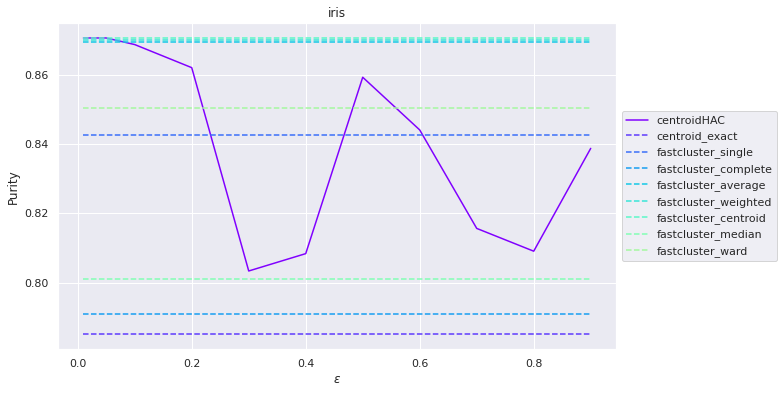

In [21]:
plot_stat("iris","Purity")

In [ ]:
def inversions_eps(dendrogram_file, eps = 0):
    n, dend, merge_costs = read_dendrogram(dendrogram_file)
    inv = 0
    one_plus_eps = 1 + eps
    for i in tqdm(range(n)):
        j = dend[i]
        while dend[j] != j:
            if merge_costs[dend[i]-n] < merge_costs[dend[j]-n]/one_plus_eps:
                inv += 1
            j = dend[j]
    return inv

def compute_inversions_basic():
    method = sys.argv[2]
    param = sys.argv[3]
    for dataset in datasets:
        if method == "centroid":
            dendrogram_file = BASE_PATH + f"basic/{dataset}/{dataset}_dend_{param}.txt"
        else:
            dendrogram_file = BASE_PATH + f"basic/{dataset}/{dataset}_dend_{method}_{param}.txt"
        for eps in [0,0.01,0.1,0.5,1]:
            inv = inversions_eps(dendrogram_file, eps)
            print(f"\nDataset: {dataset}, Method: {method}, Param: {param}, Eps: {eps}, Inversions: {inv}\n")

def compute_inversions_general():
    dataset = sys.argv[1]
    method = sys.argv[2]
    param = sys.argv[3]
    if method == "centroid":
        dendrogram_file = BASE_PATH + f"{dataset}/{dataset}_dend_{param}.txt"
    else:
        dendrogram_file = BASE_PATH + f"{dataset}/{dataset}_dend_{method}_{param}.txt"
    for eps in tqdm([1]):
        inv = inversions_eps(dendrogram_file, eps)
        print(f"\nDataset: {dataset}, Method: {method}, Param: {param}, Eps: {eps}, Inversions: {inv}\n")